# A joint multilevel model for CAR 
Using multilevel.CARLeroux
## Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF] [ S | GMRF] $$

In [1]:
## Run the script
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')
source("model2_multilevel/run-joint-multilevel.R")


[1] "Load data source and preprocess"


Loading required package: MASS
Loading required package: Rcpp

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [2]:
DD

response,Disttoroadm,Populationm,Elevationm,MeanTempm
NA,277,517,0,0
1,2556,509,0,0
1,3242,3670,0,0
NA,204,2436,0,0
NA,553,1895,0,0
0,906,1923,0,0
0,1120,3143,0,0
NA,279,2068,0,0
1,197,2536,0,0
NA,1428,3072,0,0


In [2]:

trials = rep(1,2 *nK)
burnin = 5000
n.sample = 10000
thin = 1

burnin = 500
n.sample = 1000
thin = 1

l <- list()
i = 1
nS = dim(Py)[1]
validate = createFolds(y = DataFrame$species, k=7 , returnTrain = FALSE)
validate.index.presences = lapply(validate, function(x){x + nS})

## customised for the multilevel preprocessing (i.e. DD instead of the trad. variable that I called `DataFrame` )
DD$presences <- DD$response
DD$predicted_values_CV <- NA


## Configure correlation for each cell.
## In this case, the correlation (similar to nugget effect) will be the same for all cells in P and for all cells in S.
## It can also be changed to assign correlations for same cell (i.e. the correlation between the cell i,j in S is the same as in P)
ind.re = c(rep(1,nK),rep(2,nK))



In [ ]:
for (fold in validate.index.presences) {
    
    ## Substitue by NA (to be predicted..)
    DD$response[fold] <- NA
    
    model2 <- S.CARmultilevel(formula,family = 'binomial',
                             trials=trials,
                             W=M_bis,
                             ind.area=idarea,
                             #ind.re=factor(idarea),
                             ind.re = factor(ind.re),
                             rho=1,
                             burnin=burnin,
                             n.sample=n.sample,
                             data=DD)
    
    ## return DataFrame$species to original 
    ## Beware of DD...
    DD$response <- DD$presences
    ## Return original values
    ## Aquí hay que ver si los fitted values corresponden al indice 
    predicted.probability = model2$fitted.values[fold]
    DD$predicted_values_CV[fold] <- predicted.probability

    pROC_obj <- roc(DD$response[fold],predicted.probability)

    l[[i]] <- pROC_obj
    i = i + 1
}

In [88]:
presences.index = seq(nK + 1 ,dim(DD)[1])

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”

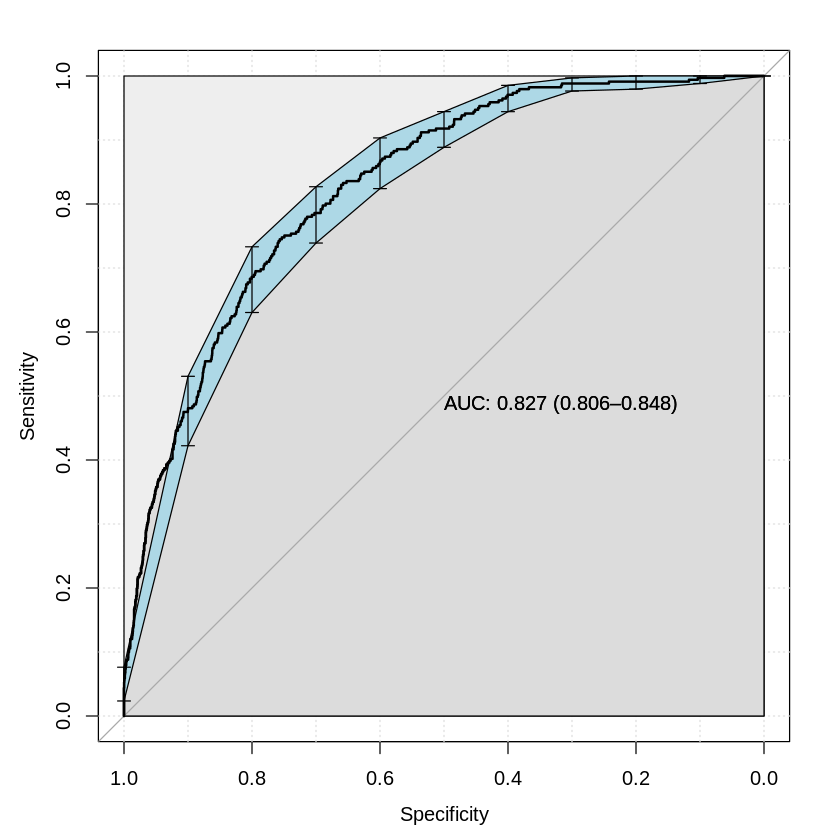

In [89]:
pROC_obj <- roc(DD$response[presences.index],DD$predicted_values_CV[presences.index],
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")



## Perfom fitting for all data 

In [5]:
DD$response

[1] NA  1  1 NA NA  0  0 NA  1 NA NA  1  0 NA  0  0 NA NA NA NA  1  1  1 NA
  [25] NA  1  0  1 NA NA NA  1 NA  1  1  1  1  0 NA NA  1  0  0  1  1 NA NA  0
  [49]  1  1  1  1  1  1  0  1  1  1  1 NA  1 NA  1  1 NA  0  1  1  1  1  1  0
  [73]  1  1 NA  1  1 NA  0  0 NA NA NA  1  1  0  1  1  1  1  0  0  0 NA NA NA
  [97]  0  1  1  0 NA NA NA  1 NA NA NA  1  1  1  1  1  0  0  0 NA  0  0 NA NA
 [121]  1  0  1  0  0  0  1  1 NA NA  1  1 NA NA NA  1  1  1  1 NA  0  0 NA NA
 [145]  1  1  0  0  0  1 NA  1  1 NA NA NA  1 NA  0 NA  0 NA  1  1  1  0  1  1
 [169]  0  0  1  1  1 NA  0  0  0  1  1 NA NA NA NA NA  1 NA  1 NA NA NA  1  1
 [193] NA  1  1  1  1  1  0  1 NA  1  0  1  0 NA  1 NA  1  1 NA NA  0  1 NA NA
 [217]  1  0  1  0  1  1  1  1  0  1  1  1  1  1  0 NA NA NA  1  1  1 NA NA  0
 [241]  1  1 NA NA NA  0  0  0  1  0 NA  1  0 NA NA NA  1  1  0 NA  0  0  1  0
 [265]  0  1 NA NA NA  1 NA NA  1  0 NA  1  0  1  0 NA NA NA  1  1 NA NA  0 NA
 [289]  1  1  1  1 NA  1  1 NA  1  1  1  1  1  1 NA NA  1 NA  0  0  0  0  1 NA
 [313]  1  1  0  0 NA NA NA  1  1  1  1  1  1  1  1  1  1 NA  1  1 NA NA NA NA
 [337]  1  0 NA  1  1  1 NA NA NA  1  1  1  1 NA NA NA  0  1  1  1  1  1  1  1
 [361]  1  1 NA  1  1  1 NA  1 NA NA NA NA NA NA  1 NA  1 NA NA  1 NA  1  0 NA
 [385]  0 NA  1  1  1 NA  1  1  1  1  1  1  1  1  1  1  1 NA NA NA  1  1  0  0
 [409] NA NA  1  1  1 NA NA  1  1  1  1 NA NA  1  1  1 NA NA NA  1 NA  1  1  1
 [433]  1  1  1  1  1  1 NA  1 NA NA NA  0  1 NA NA NA  1  1  1 NA NA NA NA  1
 [457]  1  1  0 NA  1 NA  0  0 NA  1 NA  1  1  1  1 NA  1  1  1 NA NA NA  0  0
 [481] NA NA NA  1 NA NA  1  0 NA  1  1  0 NA  1  1  1  1  1 NA  0 NA  1  1  1
 [505] NA NA  1  0  1  1  1  1  1  1  1  1  0 NA  1  1  1  0  1  1  1  1  0  1
 [529]  1  1  1  1  1  1  1  1  0  0  1  1  1  1  1  1 NA  1  1  1 NA NA  0  1
 [553]  1  1  1  1  1  0  1  1  1  1  1  1  1  1  0  0  1  1  1  1  1  0  1  1
 [577]  1  1  1  1  1  1  1  0  1  1  1  1  1  0 NA NA  0  1  1  1  1 NA  1  1
 [601]  1  1  1  1  1  1 NA  1  1  1  1  0  1  1  0  1  1  1  1  1  1  1  1  1
 [625]  1 NA  1  1  1  1  1 NA  1 NA NA NA NA  1  1  1  1  1  1  1 NA  1  1  1
 [649]  1  1  1  1  1  1  1  1  1  1  1  1  1 NA  1  1  1  1  0  1  0  0  1 NA
 [673] NA  0 NA  1  1  1  1  1  1  0  1  1  1  1  1  1 NA NA NA NA  1  1  1  1
 [697]  1  1  1  1  1  1  1  1  1 NA  0 NA NA NA NA NA NA  0  1  1 NA NA NA  1
 [721] NA  1  1  1  0  1  1  1  1  1  1  1  1  0  1  1  1 NA NA  1  1  1  1  1
 [745]  1  1  1  1  1  1  1  1  0  1  0  1  1  1  1 NA NA  1 NA  1 NA  1 NA NA
 [769]  1 NA  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1 NA  0  1  1  1
 [793]  1  1  1  1  1 NA NA  1  1  1 NA  1  1 NA NA  1 NA  0  0  1  1 NA  1  1
 [817] NA  0  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  0  1  1
 [841]  1  1  1  1  1  1  0 NA  1 NA  1  0 NA NA  1  1  0  0  1 NA  0  1  1 NA
 [865] NA  1  1  1  1  1  1  1 NA  1  1  1  1 NA  1  1  1  1  1  1  1  1  0  1
 [889]  1  1  1  0  1  1  1  1  1  1 NA  1  1  1  0 NA  0  1  1  1  1  0  1 NA
 [913]  1 NA  1  1  1 NA  1  1 NA NA  1  1 NA  0  1  1 NA  1  0  0  1  1  1  1
 [937]  1  1  1  1  1  1  1  1  1  0  1  0  1  1 NA  1 NA  1  1 NA  1  1  1  1
 [961]  1  1 NA  1  1  1  1  1  1  1  1  1  1 NA  1  0  1  1 NA  1 NA  1  0 NA
 [985]  1  1  0  1  1  1  1  1  1  1 NA  1  0  1 NA  1 NA  1  1  1  1  0  1  1
[1009]  1  1  1  1  1  1  1  1  1  1  0  1  1  1 NA  1  1  1  1  1  1  1  1  1
[1033]  1  1 NA NA NA  1  1  1  0  1  1  1  1  1  1  0  0  0  1  1 NA NA  1  0
[1057]  1  1  1 NA  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 NA NA  1  1  1
[1081]  1  1  1  1  0  1  1  0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1
[1105]  1  1  1 NA  0  0  0 NA NA  1  1 NA  1  1  1  1  1  1  1  0  1  1  1  1
[1129]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  1  1
[1153]  1  1  1  1  1  1  1  1  1  0  1  1  0  0 NA NA  0  1  1  1  1  1  0  0
[1177]  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
[1201]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

In [ ]:
model2 <- S.CARmultilevel(formula,family = 'binomial',
                          trials=trials,
                          W=M_bis,
                          ind.area=idarea,
                          #ind.re=factor(idarea),
                          ind.re = factor(ind.re),
                          rho=1,
                          burnin=burnin,
                          n.sample=n.sample,
                          data=DD)

## Remember to check likelihood modelfit

In [90]:
model2$modelfit

DIC           p.d          WAIC           p.w          LMPL 
    3766.4576      239.2094     3763.7784      221.9879    -1880.2475 
loglikelihood 
   -1644.0195

In [91]:
model2$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),0.4623,0.1482,0.7606,500,97.2,9.1,3.5
Disttoroadm,-0.0002,-0.0003,-0.0001,500,97.2,21.8,0.2
Populationm,0.0000,-0.0001,0.0001,500,97.2,17.5,-3.9
Elevationm,-0.0001,-0.0002,0.0001,500,97.2,3.8,-1.1
MeanTempm,-0.0009,-0.0010,-0.0007,500,97.2,6.6,-1.1
tau2,1.3250,0.9783,1.7857,500,100.0,2.6,-7.0
sigma2,2.3587,0.6433,15.6917,500,100.0,500.0,-1.8
rho,1.0000,1.0000,1.0000,NA,NA,NA,NA


In [103]:
## Function for extracting mean and tails.
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}

In [92]:
dim(model2$samples$phi)

[1]  500 4060

In [100]:
## Uncomment this if independent random effect is defined per cell 
## i.e. dim(model2$samples$zeta) == dim(model2$samples$phi)
#sample.re <- t(model2$samples$phi + model2$samples$zeta)

In [113]:
## Uncomment this if independent random effect is defined per process
## i.e. dim(model2$samples$zeta)[1] == 2 (one for each process)
sample.re.S <- model2$samples$phi + model2$samples$zeta[,1]
sample.re.P <- model2$samples$phi + model2$samples$zeta[,2]
#dim(model2$samples$fitted) = has double the number of cells (i.e. one per process)
post.sample = data.frame(model2$samples$fitted)
sample.P <- post.sample[,1:nK]
sample.S <- post.sample[,(nK +1) : (2*nK) ]

In [105]:
### Bernoulli sampling
pss  <- post.sample %>% mutate_all(function(p) rbernoulli(1,p))
## divide samples for S and P according to the order given up
pred.S <- pss[,1:nK]
pred.P <- pss[,(nK +1) : (2*nK) ]
nsample <- nrow(pred.S)
ProbS <- colSums(pred.S) / nsample
ProbP <- colSums(pred.P) / nsample
ProbPS = ProbP * ProbS

###  Reduce to tails and means

In [135]:
P = getUpperLowerCI(sample.P,prefix = 'P',MARGIN = 2)
S = getUpperLowerCI(sample.S,prefix = 'S',MARGIN = 2)
re.S = getUpperLowerCI(sample.re.S,prefix = 'reS',MARGIN = 2)
re.P = getUpperLowerCI(sample.re.P,prefix = 'reP',MARGIN = 2)
phi = getUpperLowerCI(model2$samples$phi,prefix = 'phi',MARGIN = 2)

In [136]:
chain <- cbind(TDF$cellids,phi,re.S,re.P,P,S,ProbP,ProbS,ProbPS)

In [138]:
## Save to posterity


In [134]:
P

,P_q025,P_median,P_q0975,P_mean,P_variance
X1,0.42428621,0.8469811,0.9763200,0.8056825,0.022118056
X2,0.34111463,0.6818405,0.9541928,0.6796696,0.025910907
X3,0.22392422,0.5946631,0.8585775,0.5765765,0.035038559
X4,0.22204208,0.5319116,0.8108196,0.5189707,0.028533857
X5,0.24168941,0.5793824,0.7710782,0.5507016,0.024323843
X6,0.11907631,0.5625527,0.8658388,0.5130830,0.049330419
X7,0.04662196,0.5707669,0.9436994,0.5260364,0.079302744
X8,0.67563757,0.9171107,0.9938890,0.8962125,0.007255699
X9,0.69922607,0.9344823,0.9782410,0.9066182,0.005659408
X10,0.61438942,0.8499305,0.9779176,0.8362929,0.008998101


### Extract and export Random Effects in the shape of raw sample

In [188]:
model2$samples$zeta

Markov Chain Monte Carlo (MCMC) output:
Start = 1 
End = 1 
Thinning interval = 1 
[1] NA

In [155]:

sample.re <- t(model2$samples$phi + model2$samples$zeta)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_randomeffect_multilevel.csv'
write.csv(re.chain,file2)

ERROR: Error in model2$samples$phi + model2$samples$zeta: non-conformable arrays


In [166]:
sample.re <- t(model2$samples$phi)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_phi_multilevel.csv'
write.csv(re.chain,file2)

In [167]:
sample.re <- t(model2$samples$zeta)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_zeta_multilevel.csv'
write.csv(re.chain,file2)

Warning message in cbind(TDF$cellids, sample.re):
“number of rows of result is not a multiple of vector length (arg 1)”

In [168]:
## P and S
## divide samples for S and P according to the order given up
fitted = model2$fitted.values
S <- fitted[1:nK]
P <- fitted[(nK +1) : (2*nK) ]
chain = cbind(TDF$cellids,S,P)
file_ = '/outputs/presence_only_models/modelCAR_model2_PS_multilevel.csv'
write.csv(chain,file_)


## Diagnostics, Mr. Gelmans, et.al

## Sample the posterior 

In [165]:
chain = cbind(TDF$cellids,probpres,prob_pps,prob_pss)
file_ = '/outputs/presence_only_models/modelCAR_model2_fitted_multilevel.csv'
write.csv(chain,file_)

## Posterior análisis with a varying C $\tau^2, \sigma^2$ denominator

In [609]:
# Read the file
bfile = '/outputs/presence_only_models/joint-model2-benchmark-denominator.csv'
res <- read.csv(bfile)

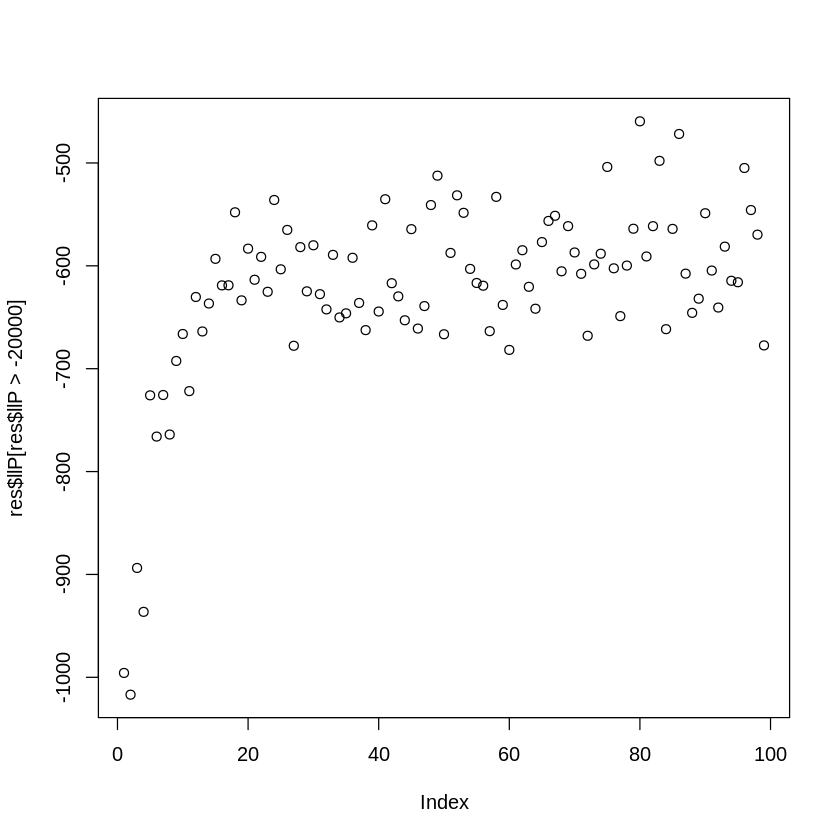